# Drawing figures for the SIGIR paper

In [441]:
from sklearn.preprocessing import normalize

In [546]:
y2 = [1,4,1.5,0.9,0.8]
y1 = [1.1,1.5,1.2,1,0.8]

x1 = [1,2,3,4,5]
cols = ['r', 'r', 'g', 'r', 'r' ]

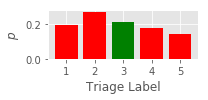

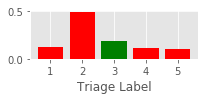

In [554]:
for i, (y, fname) in enumerate(zip([y1, y2], ['bad_prediction', 'worse_prediction'])):
    plt.subplots(figsize=(3,1.5))
    np.array(y).reshape(1,-1)
    y = normalize(np.array(y).reshape(1,-1), norm='l1')
    ax = plt.bar(x1, y[0], color=cols)
    plt.xticks([1,2,3,4,5])
    plt.xlabel('Triage Label')
    if i==0:
        plt.ylabel('$p$')
    plt.tight_layout()
    plt.savefig(fname+'.png')
    plt.show()

In [497]:
y2 = [0,0,1,0,0]
y1 = [1.1,1.5,1.2,1,0.8]

x1 = [1,2,3,4,5]

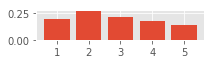

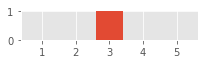

In [498]:
for y, fname in zip([y1, y2], ['bad_prediction', 'worse_prediction']):
    plt.subplots(figsize=(3,1))
    np.array(y).reshape(1,-1)
    y = normalize(np.array(y).reshape(1,-1), norm='l1')
    ax = plt.bar(x1, y[0])
    plt.xticks([1,2,3,4,5])
    plt.tight_layout()
    plt.show()

In [489]:
y = [1.1,1.5,1.2,0.8,0.4]

x1 = [1,2,3,4,5]
cols1 = ['r', 'r', 'g', 'r', 'r' ]
cols2 = ['r', 'r', 'r', 'r', 'g' ]

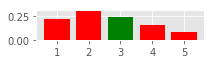

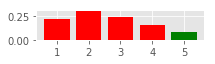

In [490]:
for cols, fname in zip([cols1, cols2], ['bad_prediction', 'worse_prediction']):
    plt.subplots(figsize=(3,1))
    np.array(y).reshape(1,-1)
    y = normalize(np.array(y).reshape(1,-1), norm='l1')
    ax = plt.bar(x1, y[0], color=cols)
    plt.xticks([1,2,3,4,5])
    plt.tight_layout()
    plt.savefig(fname+'.png')
    plt.show()

# Code for real

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re

In [2]:
import EpDDM2

In [3]:
import sys
import os
tornado_path = os.path.abspath('../tornado')
sys.path.insert(0, tornado_path)

In [4]:
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

In [351]:
plt.style.use('ggplot')

In [48]:
from importlib import reload
EpDDM2 = reload(EpDDM2)

In [49]:
CDDM = EpDDM2.EpDDM

In [56]:
def generate_data(n_samples, p, rate=0.5):
    # p = [ Pr(y=1|x=0), Pr(y=1|x=1) ]
    # rate is proportion of x=1 (rather than x=0)
    x = np.array([ np.random.choice(2, p=[1-rate, rate]) for i in range(n_samples) ])
    y = [ np.random.choice(2, p=[1-p[i], p[i]]) for i in x ]
    x = x.reshape(-1, 1)

    return x, y

class Experiment:
    
    pre_drift_n = 1000
    post_drift_n = 1000
    
    def __init__(self, probs, detector, model, rates, parameter=None):
        # probs = [a,b,c,d]
        # Before drift:
        # P(1|0) = a
        # P(1|1) = b
        # After drift:
        # P(1|0) = c
        # P(1|1) = d
        self.probs = probs
        self.detector = detector
        self.model = model
        self.result = None
        self.rates = rates
        self.parameter = parameter
        
    def run_experiment(self):
        x1, y1 = generate_data(Experiment.pre_drift_n, self.probs[:2], self.rates[0])
        x2, y2 = generate_data(Experiment.post_drift_n, self.probs[2:], self.rates[1])
        # return either none or the point of detection
        model = self.model
        if type(model)==str:
            model = eval(model)()
        detector = self.detector
        if type(detector)==str:
            detector = eval(detector)()
        monitor = []
        # Calibrate the detector
        for i in range(len(x1)):
            y_ = y1[i: i+1]
            x_ = x1[i: i+1]
            model.partial_fit(x_, y_, classes=[0,1])
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, x_[0])
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
#         print(monitor)
#         print(detector.drift_threshold)
#         print('err rate', np.mean(np.array(prs).flatten()))
        monitor = []
        for i in range(len(x2)):
            y_ = y2[i: i+1]
            x_ = x2[i: i+1]
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, /y_)
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
            
            if drift_status:
                self.result = i+1
#                 print('detected drift at', i)
                return i
#         print(monitor)
            
            # TODO: partial_fit model?
            
#            print(i, y_, x_, self.result)
        
        return
    
    def get_result_row(self):
        return pd.DataFrame({'Experiment': [f'{self.detector} + {self.model}'],
                            'Outcome': [self.result],
                           'Parameter': [self.parameter]})
    
class RepeatedExperiment:
    
    n_repeats = 1
    
    def __init__(self, probs, detector, model, rates):
        
        self.experiments = []
        self.detector = detector
        self.probs = probs
        self.model = model
        self.rates = rates
        
    def run_experiments(self):
#         print(self.detector, '\n\n')
        for i in range(RepeatedExperiment.n_repeats):
            new_experiment = Experiment(self.probs, self.detector, self.model, self.rates)
            new_experiment.run_experiment()
            self.experiments.append(new_experiment)
        
    def get_summary(self):
        results = [ exp.result for exp in self.experiments ]
        detections = [ i for i in results if i ]
        latency = np.mean(detections)
        try:
            recall = len(detections) / len(results)
        except:
            recall = 0
#         print(results)
        return {'latency': latency, 
                'detection_rate': recall }
    
class MultiDetectorExperiments:
    
    def __init__(self, probs, detectors, models, rates=[0.5, 0.5]):
        self.probs = probs
        self.detectors = detectors
        self.models = models
        self.repeated_experiments = {}
        self.rates = rates
        
    def run_experiments(self):
        for detector in self.detectors:
            for model in self.models:
                new_experiments = RepeatedExperiment(self.probs, eval(detector), eval(model), self.rates)
                new_experiments.run_experiments()
                name = f'{model} + {detector}'
                self.repeated_experiments[name] = new_experiments
        
    def results_table(self):
        table = pd.DataFrame(columns=['Experiment', 'Latency', 'Detection Rate'])
        i = 0
        for (name, repeated_experiment) in self.repeated_experiments.items():
            summary = repeated_experiment.get_summary()
            latency, detection_rate = summary['latency'], summary['detection_rate']
            table.loc[i] = [name, latency, detection_rate]
            
#             results = [ exp.result for exp in repeated_experiment.experiments ]
#             detections = [ i for i in results if i ]
#             print(detections)
#             latency = np.mean(detections)
            
            i += 1
        return table

In [289]:
class NB: # Naive Bayes
    def __init__(self):
        self.counts = { 0: np.array([1,1]), 1: np.array([1,1])}
    def partial_fit(self, x, y, classes=None):
        for x_, y_ in zip(x, y):
            self.counts[x_[0]][y_] += 1
        return self
    def predict_proba(self, x):
        ret = []
        for x_ in x:
#             x_ = x_[0]
            while not type(x_)==np.int64 and not type(x_)==int:
                x_ = x_[0]
            ret.append( self.counts[x_]/np.sum(self.counts[x_]) )
        ret = np.array(ret)
        return ret
    def predict(self, x):
        probs = self.predict_proba(x)
        ret = [ max([0,1], key=lambda x: line[x]) for line in probs ]
        return ret

In [293]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NB']

def experiment(probs, rates, param=None, repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, param)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

# Detection Delay, High Confidence

In [ ]:
def delay_experiment(epsilon):
    probs = [1-epsilon, epsilon, epsilon, 1-epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=20)

def latency_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.3, num=10):
        results = results.append(delay_experiment(epsilon))
    return results

latency = latency_experiments()

In [ ]:
# Tidy data so that seaborn will accept it
latency_ = latency[~(latency['Outcome'].isna())]
latency_['Outcome'] = latency_['Outcome'].astype('int')
latency_['Experiment'] = latency_['Experiment'].astype('category')

In [ ]:
# Create plot
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', notch=True, data=latency_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='Detection Delay (Timesteps)', title='Delay vs Noise');

# Fix the ticks
tick_labs = [ f'{float(i.get_text()):.2f}' for i in g.get_xticklabels()]#[::2] ]
g.set_xticklabels(tick_labs);
plt.legend(loc='upper left')
plt.savefig('delay_noise_plt.png');

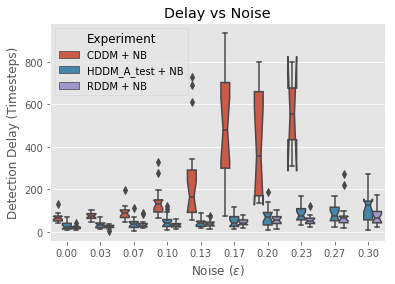

In [559]:
# Create plot
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', notch=True, data=latency_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='Detection Delay (Timesteps)', title='Delay vs Noise');

# Fix the ticks
tick_labs = [ f'{float(i.get_text()):.2f}' for i in g.get_xticklabels()]#[::2] ]
g.set_xticklabels(tick_labs);
plt.legend(loc='upper left')
plt.savefig('delay_noise_plt.png');

# False Positives vs Noise

In [389]:
def high_noise_experiment(epsilon):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=100)

def high_noise_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(high_noise_experiment(epsilon))
    return results

high_noise = high_noise_experiments()

In [368]:
post_drift_n = 1000

def get_fp_df(results):
    ret = results.copy()
    ret['Outcome'] = ret['Outcome'].apply(lambda x: 0 if x==None else 1/x)
    return ret

def get_fp_rate_df(results):
    experiments = list(results.Experiment.unique())
    fp_df = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in results.Experiment.unique():
        for param in results.Parameter.unique():
            hn_i = results[(results.Experiment==exp) & (results.Parameter==param)]
            positives = [ i for i in hn_i.Outcome if i!=None]
            fp_df.loc[i, :] = [exp, param, len(positives)/len(hn_i)]
            i += 1
    fp_df['Experiment'] = fp_df['Experiment'].astype('category')
    fp_df['Parameter'] = fp_df['Parameter'].astype('float')
    fp_df['Outcome'] = fp_df['Outcome'].astype('float')
    return fp_df

In [369]:
high_noise_ = get_fp_df(high_noise)

In [391]:
high_noise_2 = get_fp_df(high_noise)

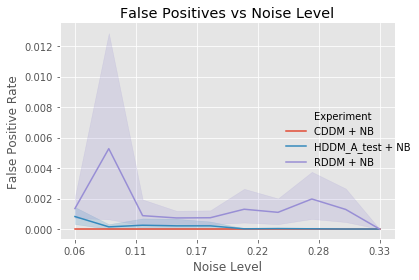

In [577]:
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=4, data=high_noise_2)#, legend=False)
g.set(xlabel='Noise Level', ylabel='False Positive Rate', title='False Positives vs Noise Level');

# Fix the ticks
# tick_labs = [ f'{float(tick.get_text()):.2f}' for i, tick in enumerate(g.get_xticklabels())]#[::2] ]
g.set_xticklabels(tick_labs)
# plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('noise_fp_plt.png');

# Virtual Drift False Positives

In [340]:
def vd_experiment(epsilon):
    probs = [1, 0.5, 1, 0.5]
    rates = [0.5-epsilon, 0.5+epsilon]
    return experiment(probs, rates, param=epsilon, repeats=20)

def vd_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.49, num=10):
        results = results.append(vd_experiment(epsilon))
    return results

vd_df = vd_experiments()

In [379]:
vd_fps = get_fp_df(vd_df)
vd_fps

,Experiment,Outcome,Parameter
0,CDDM + NB,0.000000,0.00
0,HDDM_A_test + NB,0.000000,0.00
0,RDDM + NB,0.006329,0.00
0,CDDM + NB,0.000000,0.00
0,HDDM_A_test + NB,0.000000,0.00
0,RDDM + NB,0.001520,0.00
0,CDDM + NB,0.000000,0.00
0,HDDM_A_test + NB,0.000000,0.00
0,RDDM + NB,0.001565,0.00
0,CDDM + NB,0.000000,0.00


In [380]:
vd_fps['Parameter'] = vd_fps['Parameter'] * 2

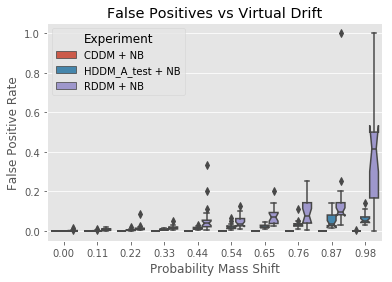

In [555]:
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', notch=True, data=vd_fps)
g.set(xlabel='Probability Mass Shift', ylabel='False Positive Rate', title='False Positives vs Virtual Drift');

# Fix the ticks
tick_labs = [ f'{float(tick.get_text()):.2f}' for i, tick in enumerate(g.get_xticklabels())]#[::2] ]
g.set_xticklabels(tick_labs)
plt.savefig('virtual_drift_plt.png');

# Old Experiments

In [159]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NaiveBayes2']
rates = [0.5, 0.5]

def high_noise_experiment(epsilon, repeats=10):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, epsilon)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

def high_noise_experiments(repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(high_noise_experiment(epsilon, repeats))
    return results

high_noise = high_noise_experiments()

In [188]:
def get_fp_data(data):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in data.Experiment.unique():
        for param in data.Parameter.unique():
            results_i = data[(data['Experiment']==exp) & (data['Parameter']==param)]
            if len(results_i)==0:
                continue
            detection_rate = len([i for i in results_i['Outcome'] if i])/len(results_i)
            results.loc[i, :] = [exp, param, detection_rate]
            i += 1
    return results

In [189]:
high_noise_fp = get_fp_data(high_noise)
high_noise_fp.head()

,Experiment,Parameter,Outcome
1,CDDM + NaiveBayes2,0,0
2,CDDM + NaiveBayes2,0.0555556,0
3,CDDM + NaiveBayes2,0.111111,0
4,CDDM + NaiveBayes2,0.166667,0
5,CDDM + NaiveBayes2,0.222222,0


In [368]:
# Detection latency for high confidence
probs = [0.9, 0.1, 0.1, 0.9]


detectors = ['CDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[30]
[17]
[9]
[1]


,Experiment,Latency,Detection Rate
0,SimpleModel + CDDM,30.0,1.0
1,SimpleModel + HDDM_A_test,17.0,1.0
2,SimpleModel + RDDM,9.0,1.0
3,SimpleModel + DDM,1.0,1.0


In [364]:
# False positives with high noise
probs = [0.55, 0.45, 0.55, 0.45]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[None]
[None]
[470]
[None]


,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,NaN,0.0
2,SimpleModel + RDDM,470.0,1.0
3,SimpleModel + DDM,NaN,0.0


In [316]:
# virtual drift masking real drift
probs = [1, 0.5, 1, 0.5]
rates = [0.01, 0.99]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models, rates)

exp.run_experiments()
exp.results_table()

,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,15.5,1.0
2,SimpleModel + RDDM,48.0,0.9
3,SimpleModel + DDM,2.0,0.2


They have three common parameters: the confidence values
170 for drifts (αD =0.001) and warnings (αW =0.005), and the direction of the error, which can be one-sided (t=0, only
increments), default for HDDMW , or two-sided (t=1, error increments and decrements), and default for HDDMA.
Finally, HDDMW has an extra parameter (λ=0.05) that is used to control how much weight is given to more recent
data in comparison to older data.

In [639]:
import os

from streams.generators.__init__ import *

stream_names = ["sine", "circles", "mixed", "led"]
stream_objs = [SINE1, CIRCLES, MIXED, LEDConceptDrift]

for stream_name, sobj in zip(stream_names, stream_objs):
    for i in range(10):
        project_path = "data_streams2/_synthetic/" + stream_name + "/"
        if not os.path.exists(project_path):
            os.makedirs(project_path)

        file_path = project_path + stream_name + f'_{i}'

        stream_generator = sobj(concept_length=20000, random_seed=i)
        stream_generator.generate(file_path)

You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_0.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_1.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_2.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_3.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear 

In [643]:
# Test
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

def run_tornado_experiment(dataset_name):
    
    # for example, dataset_name='circles_0'
    
    # 1. Creating a project
    project = Project("experiments2", dataset_name)
    
    # 2. Loading an arff file
    dataset_type = dataset_name.rstrip('0123456789_')
    dataset_path = os.path.abspath(f'data_streams2/_synthetic/{dataset_type}/{dataset_name}.arff')
    labels, attributes, stream_records = ARFFReader.read(dataset_path)
    attributes_scheme = AttributeScheme.get_scheme(attributes)

    # 3. Initializing a Classifier-Detector Pairs
    pairs = [
             [NaiveBayes(labels, attributes_scheme['nominal']), CDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), RDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), HDDM_A_test()],
             [Perceptron(labels, attributes_scheme['numeric']), CDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), RDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), HDDM_A_test()]
            ]

    # 4. Creating a color set for plotting results
    colors = [Color.Indigo[1], Color.Blue[1], Color.Green[1], Color.Lime[1], Color.Yellow[1],
              Color.Amber[1], Color.Orange[1]][:len(pairs)]

    # 5. Defining actual locations of drifts, acceptance delay interval, and vector of weights
    actual_drift_points = [20000, 40000, 60000, 80000]
    drift_acceptance_interval = 250
    w_vec = [1, 1, 1, 1, 1, 1]

    # 6. Creating a Prequential Evaluation Process
    prequential = PrequentialMultiPairs(pairs, attributes, attributes_scheme,
                                        actual_drift_points, drift_acceptance_interval,
                                        w_vec, project, color_set=colors, legend_param=False)

    prequential.run(stream_records, 1)

In [609]:
from glob import glob

In [ ]:
for i, path in enumerate(glob('./data_streams2/_synthetic/*/*.arff')):
    dataset_name = re.match(r'.*/([\w\d]+).arff', path).group(1)
    print(i, dataset_name)
    run_tornado_experiment(dataset_name)

0 led_2
The project path "experiments2/led_2/20200220_172357/" is created.
NB + CDDM [0.0, 171.44, 18184.405618172605] [750, [0, 0], 0, 3, 6.872, 104278.11100991676]
NB + RDDM [0.1044, 172.936, 5575.757266255096] [750, [0, 0], 3, 3, 64.048, 112.50373435905203]
NB + HDDM.A.test [0.1042, 173.0, 5895.181264786515] [750, [0, 0], 3, 3, 1.312, 397.85496704280376]
PR + CDDM [0.0, 70.688, 12893.996647617314] [750, [0, 0], 0, 3, 6.872, 104106.71698587248]
PR + RDDM [0.1153, 73.616, 4285.5809653992765] [750, [0, 0], 5, 3, 64.048, 105.05735769402236]
PR + HDDM.A.test [0.116, 73.648, 4576.4082031091675] [732, [40233, 1], 2, 2, 1.312, 388.2968557300046]
THE END

1 led_3
The project path "experiments2/led_3/20200220_173034/" is created.
NB + CDDM [0.0, 171.408, 19434.65603364166] [750, [0, 0], 0, 3, 6.872, 106028.09456491377]
NB + RDDM [0.1015, 172.84, 6105.653871549293] [750, [0, 0], 5, 3, 64.048, 126.51783879846334]
NB + HDDM.A.test [0.1018, 172.616, 3810.6149918748997] [750, [0, 0], 4, 3, 1.312,

In [612]:
results = pd.DataFrame(columns=['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay'])

for i, path in enumerate(glob('./experiments2/*/*/*.txt')):
    results = results.append(parse_results(path))
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,mixed_3,CDDM,NAIVE BAYES,4,0,0,0.0,45.77,13513.35,354
2,mixed_3,RDDM,NAIVE BAYES,4,0,0,14.62,103.1,407.0,407
3,mixed_3,HDDM.A.test,NAIVE BAYES,4,0,0,14.77,40.49,536.91,258
4,mixed_3,CDDM,PERCEPTRON,4,0,0,0.0,15.77,13389.86,284
5,mixed_3,RDDM,PERCEPTRON,4,0,0,18.509999999999998,73.1,273.75,582
6,mixed_3,HDDM.A.test,PERCEPTRON,4,0,1,18.47,10.49,384.12,372
1,mixed_4,CDDM,NAIVE BAYES,4,0,0,0.0,45.77,13735.3,354
2,mixed_4,RDDM,NAIVE BAYES,4,0,0,14.62,103.1,414.96,407
3,mixed_4,HDDM.A.test,NAIVE BAYES,4,0,0,14.77,40.49,547.19,258
4,mixed_4,CDDM,PERCEPTRON,4,0,0,0.0,15.77,13441.88,284


In [637]:
def get_the_data_table_ready_for_latex(results):
    
    latex_table = pd.DataFrame()
    
    ##########################################
    ###### Create the experiment column ######
    ##########################################
    
    def get_ds_name(str_):
        # get dataset name
        return re.match(r'([a-z]+).*', str_).group(1).upper()
    ds_names = results['Dataset'].apply(get_ds_name)
    
    det_names_map = {'HDDM.A.test': r'HDDM-A', 'CDDM': 'CDDM', 'RDDM': 'RDDM'}
    det_names = results['Detector'].map(det_names_map)
    
    model_names_map = {'NAIVE BAYES': 'NB', 'PERCEPTRON': 'PERC'}
    model_names = results['Model'].map(model_names_map)
    
    exp_names = ds_names + ', ' + det_names + ' + ' + model_names
    latex_table['Experiment'] = exp_names
    
    ##########################################
    ###### Precision and Recall         ######
    ##########################################
    
    # Calculate precision and recall
    tp = results['TP'].astype('float')
    fp = results['FP'].astype('float')
    fn = results['FN'].astype('float')
    prec = ( tp / (tp + fp) ).reset_index(drop=True)
    prec = prec.map(lambda x: x if np.isfinite(x) else np.nan)
    rec = ( tp / (tp + fn) ).reset_index(drop=True)
    latex_table['Prec'] = prec
    latex_table['Rec'] = rec

    # Copy over other metrics
    for i in ['Memory', 'Runtime', 'Total Delay']:
        latex_table[i] = results[i].astype('float')
        
    ##########################################
    ###### Mean and Standard Deviation  ######
    ##########################################
    
    means_table = pd.DataFrame(columns=latex_table.columns, 
                               index=latex_table['Experiment'].unique())
    for exp in latex_table['Experiment'].unique():
        this_exp = latex_table[ latex_table['Experiment']==exp ]
        
        for col in means_table.columns:
            
            if col=='Experiment':
                means_table.loc[exp, col] = exp
                continue
            
            col_vals = this_exp[col]
            
            mean = np.nanmean(col_vals)
            std = np.nanstd(col_vals)
            
            if std==0:
                display(this_exp)
            
            entry = f'{mean:.2f} ({std:.2f})'
            means_table.loc[exp, col] = entry
        
    ##########################################
    ###### Print LaTeX and return table ######
    ##########################################
        
    print( means_table.to_latex(index=False) )
    
    return latex_table, means_table

In [638]:
get_the_data_table_ready_for_latex(results);

,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13513.35,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13735.30,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13837.10,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13645.50,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13692.70,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,14384.62,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13694.80,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13424.33,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13936.68,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13807.57,354.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13513.35,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13735.30,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13837.10,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13645.50,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13692.70,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,14384.62,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13694.80,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13424.33,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13936.68,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13807.57,354.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13513.35,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13735.30,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13837.10,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13645.50,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13692.70,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,14384.62,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13694.80,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13424.33,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13936.68,354.0
1,"MIXED, CDDM + NB",1.0,1.0,45.77,13807.57,354.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"MIXED, RDDM + NB",1.0,1.0,103.1,407.00,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.96,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,431.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,424.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.13,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,437.74,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,430.09,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,413.19,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,409.87,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,411.03,407.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"MIXED, RDDM + NB",1.0,1.0,103.1,407.00,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.96,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,431.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,424.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.13,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,437.74,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,430.09,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,413.19,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,409.87,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,411.03,407.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"MIXED, RDDM + NB",1.0,1.0,103.1,407.00,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.96,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,431.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,424.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.13,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,437.74,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,430.09,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,413.19,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,409.87,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,411.03,407.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"MIXED, RDDM + NB",1.0,1.0,103.1,407.00,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.96,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,431.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,424.66,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,414.13,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,437.74,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,430.09,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,413.19,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,409.87,407.0
2,"MIXED, RDDM + NB",1.0,1.0,103.1,411.03,407.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.91,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,547.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,560.33,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,551.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,546.73,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,561.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,558.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,541.41,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,539.63,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.66,258.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.91,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,547.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,560.33,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,551.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,546.73,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,561.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,558.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,541.41,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,539.63,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.66,258.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.91,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,547.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,560.33,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,551.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,546.73,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,561.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,558.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,541.41,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,539.63,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.66,258.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.91,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,547.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,560.33,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,551.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,546.73,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,561.19,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,558.84,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,541.41,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,539.63,258.0
3,"MIXED, HDDM-A + NB",1.0,1.0,40.49,536.66,258.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13389.86,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13441.88,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13832.87,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13558.51,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13568.42,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,14066.66,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13645.70,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13284.51,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13554.81,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13456.09,284.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13389.86,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13441.88,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13832.87,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13558.51,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13568.42,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,14066.66,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13645.70,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13284.51,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13554.81,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13456.09,284.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13389.86,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13441.88,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13832.87,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13558.51,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13568.42,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,14066.66,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13645.70,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13284.51,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13554.81,284.0
4,"MIXED, CDDM + PERC",1.0,1.0,15.77,13456.09,284.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.75,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.25,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,287.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.18,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,278.84,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,291.23,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,282.65,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,271.36,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,277.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.39,582.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.75,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.25,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,287.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.18,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,278.84,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,291.23,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,282.65,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,271.36,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,277.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.39,582.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.75,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.25,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,287.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.18,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,278.84,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,291.23,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,282.65,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,271.36,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,277.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.39,582.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.75,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,273.25,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,287.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.18,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,278.84,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,291.23,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,282.65,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,271.36,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,277.24,582.0
5,"MIXED, RDDM + PERC",0.8,1.0,73.1,279.39,582.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,384.12,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,386.85,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,393.22,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,386.63,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,387.79,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,398.35,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,391.14,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,382.12,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,385.59,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,382.23,372.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,384.12,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,386.85,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,393.22,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,386.63,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,387.79,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,398.35,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,391.14,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,382.12,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,385.59,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,382.23,372.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,384.12,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,386.85,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,393.22,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,386.63,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,387.79,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,398.35,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,391.14,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,382.12,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,385.59,372.0
6,"MIXED, HDDM-A + PERC",1.0,1.0,10.49,382.23,372.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"SINE, CDDM + NB",1.0,1.0,39.02,13675.77,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13860.59,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13326.33,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13735.64,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13420.63,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13683.25,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13558.00,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13500.16,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13605.26,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13970.84,372.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"SINE, CDDM + NB",1.0,1.0,39.02,13675.77,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13860.59,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13326.33,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13735.64,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13420.63,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13683.25,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13558.00,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13500.16,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13605.26,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13970.84,372.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"SINE, CDDM + NB",1.0,1.0,39.02,13675.77,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13860.59,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13326.33,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13735.64,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13420.63,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13683.25,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13558.00,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13500.16,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13605.26,372.0
1,"SINE, CDDM + NB",1.0,1.0,39.02,13970.84,372.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.59,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,345.95,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,331.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,365.70,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,339.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,367.27,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,354.16,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,346.07,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.37,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,370.09,440.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.59,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,345.95,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,331.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,365.70,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,339.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,367.27,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,354.16,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,346.07,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.37,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,370.09,440.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.59,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,345.95,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,331.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,365.70,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,339.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,367.27,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,354.16,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,346.07,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.37,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,370.09,440.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.59,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,345.95,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,331.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,365.70,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,339.64,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,367.27,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,354.16,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,346.07,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,360.37,440.0
2,"SINE, RDDM + NB",1.0,1.0,96.34,370.09,440.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,485.24,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,475.46,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,463.83,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,486.24,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,471.09,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,498.72,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,482.97,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,480.08,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,491.54,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,498.67,238.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,485.24,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,475.46,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,463.83,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,486.24,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,471.09,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,498.72,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,482.97,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,480.08,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,491.54,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,498.67,238.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,485.24,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,475.46,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,463.83,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,486.24,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,471.09,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,498.72,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,482.97,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,480.08,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,491.54,238.0
3,"SINE, HDDM-A + NB",1.0,1.0,33.73,498.67,238.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13465.23,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13594.75,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13503.91,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13768.61,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13311.71,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13640.45,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13439.83,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13398.59,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13419.24,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13587.39,285.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13465.23,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13594.75,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13503.91,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13768.61,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13311.71,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13640.45,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13439.83,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13398.59,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13419.24,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13587.39,285.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13465.23,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13594.75,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13503.91,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13768.61,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13311.71,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13640.45,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13439.83,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13398.59,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13419.24,285.0
4,"SINE, CDDM + PERC",1.0,1.0,13.97,13587.39,285.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.61,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,241.47,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,233.24,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.66,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,237.15,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,247.30,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,244.31,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,241.75,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.54,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,251.64,427.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.61,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,241.47,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,233.24,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.66,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,237.15,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,247.30,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,244.31,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,241.75,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.54,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,251.64,427.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.61,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,241.47,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,233.24,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.66,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,237.15,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,247.30,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,244.31,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,241.75,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,246.54,427.0
5,"SINE, RDDM + PERC",0.8,1.0,71.29,251.64,427.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,368.33,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,368.82,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,359.03,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,369.85,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,362.15,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,373.93,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,367.85,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,366.67,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,369.73,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,373.87,236.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,368.33,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,368.82,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,359.03,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,369.85,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,362.15,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,373.93,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,367.85,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,366.67,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,369.73,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,373.87,236.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,368.33,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,368.82,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,359.03,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,369.85,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,362.15,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,373.93,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,367.85,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,366.67,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,369.73,236.0
6,"SINE, HDDM-A + PERC",1.0,1.0,8.68,373.87,236.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"LED, CDDM + NB",1.0,1.0,177.29,62855.99,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61686.36,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63489.35,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61353.85,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,64141.13,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62312.45,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61019.93,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61312.77,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62293.44,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63357.00,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"LED, CDDM + NB",1.0,1.0,177.29,62855.99,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61686.36,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63489.35,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61353.85,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,64141.13,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62312.45,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61019.93,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61312.77,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62293.44,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63357.00,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"LED, CDDM + NB",1.0,1.0,177.29,62855.99,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61686.36,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63489.35,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61353.85,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,64141.13,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62312.45,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61019.93,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61312.77,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62293.44,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63357.00,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"LED, CDDM + NB",1.0,1.0,177.29,62855.99,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61686.36,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63489.35,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61353.85,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,64141.13,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62312.45,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61019.93,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,61312.77,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,62293.44,750.0
1,"LED, CDDM + NB",1.0,1.0,177.29,63357.00,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"LED, RDDM + NB",1.0,1.0,233.04,2950.98,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2904.35,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3019.75,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2901.35,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3167.24,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3010.45,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2810.14,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2884.53,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2867.36,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3010.45,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"LED, RDDM + NB",1.0,1.0,233.04,2950.98,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2904.35,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3019.75,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2901.35,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3167.24,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3010.45,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2810.14,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2884.53,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2867.36,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3010.45,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"LED, RDDM + NB",1.0,1.0,233.04,2950.98,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2904.35,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3019.75,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2901.35,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3167.24,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3010.45,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2810.14,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2884.53,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,2867.36,750.0
2,"LED, RDDM + NB",1.0,1.0,233.04,3010.45,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3259.81,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3193.67,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3307.20,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3196.73,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3411.01,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3285.34,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3137.15,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3219.89,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3166.13,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3269.38,734.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3259.81,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3193.67,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3307.20,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3196.73,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3411.01,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3285.34,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3137.15,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3219.89,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3166.13,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3269.38,734.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3259.81,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3193.67,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3307.20,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3196.73,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3411.01,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3285.34,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3137.15,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3219.89,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3166.13,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3269.38,734.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3259.81,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3193.67,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3307.20,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3196.73,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3411.01,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3285.34,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3137.15,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3219.89,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3166.13,734.0
3,"LED, HDDM-A + NB",1.0,1.0,170.52,3269.38,734.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"LED, CDDM + PERC",1.0,1.0,77.54,58966.09,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58208.78,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,60805.98,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58041.29,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,61489.75,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58827.91,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58194.83,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58406.14,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,59239.72,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,60120.31,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"LED, CDDM + PERC",1.0,1.0,77.54,58966.09,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58208.78,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,60805.98,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58041.29,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,61489.75,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58827.91,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58194.83,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58406.14,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,59239.72,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,60120.31,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"LED, CDDM + PERC",1.0,1.0,77.54,58966.09,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58208.78,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,60805.98,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58041.29,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,61489.75,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58827.91,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58194.83,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,58406.14,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,59239.72,750.0
4,"LED, CDDM + PERC",1.0,1.0,77.54,60120.31,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"LED, RDDM + PERC",0.8,1.0,136.74,2277.57,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2255.50,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.70,2349.13,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2239.36,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2414.53,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2330.38,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2226.24,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2242.36,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2240.29,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2345.30,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"LED, RDDM + PERC",0.8,1.0,136.74,2277.57,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2255.50,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.70,2349.13,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2239.36,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2414.53,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2330.38,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2226.24,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2242.36,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2240.29,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2345.30,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"LED, RDDM + PERC",0.8,1.0,136.74,2277.57,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2255.50,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.70,2349.13,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2239.36,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2414.53,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2330.38,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2226.24,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2242.36,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2240.29,750.0
5,"LED, RDDM + PERC",0.8,1.0,136.74,2345.30,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2559.77,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.11,2565.54,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2597.88,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2548.77,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2647.09,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2611.72,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2507.55,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2516.97,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2522.58,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2593.09,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2559.77,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.11,2565.54,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2597.88,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2548.77,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2647.09,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2611.72,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2507.55,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2516.97,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2522.58,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2593.09,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2559.77,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.11,2565.54,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2597.88,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2548.77,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2647.09,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2611.72,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2507.55,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2516.97,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2522.58,750.0
6,"LED, HDDM-A + PERC",1.0,1.0,74.12,2593.09,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27361.95,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,28250.66,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27049.22,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26829.39,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26865.67,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27113.26,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26910.71,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26705.43,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27232.10,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26958.70,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27361.95,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,28250.66,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27049.22,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26829.39,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26865.67,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27113.26,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26910.71,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26705.43,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27232.10,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26958.70,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27361.95,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,28250.66,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27049.22,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26829.39,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26865.67,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27113.26,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26910.71,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26705.43,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,27232.10,750.0
1,"CIRCLES, CDDM + NB",1.0,1.0,39.1,26958.70,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.95,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,387.36,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,355.80,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,339.99,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,343.27,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,365.13,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.14,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,341.44,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,366.12,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,354.77,673.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.95,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,387.36,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,355.80,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,339.99,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,343.27,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,365.13,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.14,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,341.44,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,366.12,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,354.77,673.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.95,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,387.36,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,355.80,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,339.99,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,343.27,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,365.13,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.14,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,341.44,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,366.12,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,354.77,673.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.95,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,387.36,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,355.80,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,339.99,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,343.27,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,365.13,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,351.14,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,341.44,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,366.12,673.0
2,"CIRCLES, RDDM + NB",1.0,1.0,96.4,354.77,673.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,480.30,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,519.57,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,486.55,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,475.38,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,476.45,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,491.62,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,485.37,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,471.18,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,494.14,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,482.85,578.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,480.30,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,519.57,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,486.55,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,475.38,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,476.45,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,491.62,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,485.37,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,471.18,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,494.14,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,482.85,578.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,480.30,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,519.57,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,486.55,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,475.38,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,476.45,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,491.62,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,485.37,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,471.18,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,494.14,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,482.85,578.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,480.30,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,519.57,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,486.55,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,475.38,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,476.45,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,491.62,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,485.37,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,471.18,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,494.14,578.0
3,"CIRCLES, HDDM-A + NB",1.0,1.0,33.81,482.85,578.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54193.16,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,55541.39,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53279.37,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,52969.72,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53812.00,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54504.12,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53810.10,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53224.69,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53669.53,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54270.23,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54193.16,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,55541.39,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53279.37,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,52969.72,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53812.00,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54504.12,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53810.10,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53224.69,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53669.53,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54270.23,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54193.16,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,55541.39,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53279.37,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,52969.72,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53812.00,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54504.12,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53810.10,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53224.69,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,53669.53,750.0
4,"CIRCLES, CDDM + PERC",1.0,1.0,13.93,54270.23,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,666.65,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,601.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,584.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,586.45,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,623.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,606.52,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,593.31,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,627.85,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.73,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,666.65,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,601.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,584.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,586.45,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,623.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,606.52,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,593.31,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,627.85,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.73,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,666.65,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,601.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,584.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,586.45,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,623.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,606.52,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,593.31,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,627.85,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.73,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,666.65,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,601.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,584.20,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,586.45,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,623.80,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,606.52,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,593.31,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,627.85,750.0
5,"CIRCLES, RDDM + PERC",0.8,1.0,71.27,602.73,750.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,352.80,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,369.60,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,355.10,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,348.18,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,350.50,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,359.43,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,356.42,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,351.95,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,359.88,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,357.34,637.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,352.80,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,369.60,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,355.10,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,348.18,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,350.50,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,359.43,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,356.42,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,351.95,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,359.88,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,357.34,637.0


,Experiment,Prec,Rec,Memory,Runtime,Total Delay
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,352.80,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,369.60,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,355.10,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,348.18,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,350.50,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,359.43,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,356.42,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,351.95,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,359.88,637.0
6,"CIRCLES, HDDM-A + PERC",1.0,1.0,8.68,357.34,637.0


\begin{tabular}{llllll}
\toprule
             Experiment &         Prec &          Rec &         Memory &             Runtime &    Total Delay \\
\midrule
       MIXED, CDDM + NB &  1.00 (0.00) &  1.00 (0.00) &   45.77 (0.00) &   13767.20 (250.01) &  354.00 (0.00) \\
       MIXED, RDDM + NB &  1.00 (0.00) &  1.00 (0.00) &  103.10 (0.00) &      419.43 (10.15) &  407.00 (0.00) \\
     MIXED, HDDM-A + NB &  1.00 (0.00) &  1.00 (0.00) &   40.49 (0.00) &       548.07 (9.09) &  258.00 (0.00) \\
     MIXED, CDDM + PERC &  1.00 (0.00) &  1.00 (0.00) &   15.77 (0.00) &   13579.93 (215.46) &  284.00 (0.00) \\
     MIXED, RDDM + PERC &  0.80 (0.00) &  1.00 (0.00) &   73.10 (0.00) &       279.41 (5.93) &  582.00 (0.00) \\
   MIXED, HDDM-A + PERC &  1.00 (0.00) &  1.00 (0.00) &   10.49 (0.00) &       387.80 (4.86) &  372.00 (0.00) \\
        SINE, CDDM + NB &  1.00 (0.00) &  1.00 (0.00) &   39.02 (0.00) &   13633.65 (185.47) &  372.00 (0.00) \\
        SINE, RDDM + NB &  1.00 (0.00) &  1.00 (0.00) 

In [149]:
def parse_results(path):
    path = os.path.abspath(path)
    dataset_name = re.match('^.*/(.*?).txt$', path).group(1)
    with open(path) as f:
        lines = f.read().split('\n')
    headers = lines[0].rstrip(']').lstrip('[')
    headers = [ header.lstrip() for header in headers.split(',') ]
    results = pd.DataFrame(columns=headers)
    i = 1
    for line in lines[1:]:
        fields = line.split('\t')
        if fields==['']:
            continue
        results.loc[i, :] = fields
        i += 1
        
    results['Dataset'] = dataset_name
        
    # Parse "Drift Detector Stats"
    total_delay = []
    tp = []
    location_of_last_detection = []
    fp, fn = [], []
    for i in range(len(results)):
        temp = eval(results.loc[i+1, 'Drift Detector Stats'])
        tdi, [lldi, tpi], fpi, fni = temp
        total_delay.append(tdi)
        tp.append(tpi)
        location_of_last_detection.append(lldi)
        fp.append(fpi)
        fn.append(fni)
    results['Total Delay'] = total_delay
    results['TP'] = tp
    results['FN'] = fn
    results['FP'] = fp
    
    # Split up name
    models = []
    detectors = []
    for i in range(len(results)):
        name = results.loc[i+1, 'Name']
        n_match = re.match('([\w\s]+) \+ ([\w\.]+)', name)
        models.append( n_match.group(1) )
        detectors.append( n_match.group(2) )
    results['Model'] = models
    results['Detector'] = detectors
    
    # Get wanted columns in right order
    results = results[['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Avg. Error-rate', 'Avg. Total Memory', 'Avg. Total Runtime', 'Total Delay']]
    results.columns = ['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay']
        
    return results

In [151]:
experiments = ['sine1_w_50/20200203_112227', 'circles_w_500/20200203_112801', 'mixed_w_50/20200203_113339', 'led_w_500/20200203_115246']

results = pd.DataFrame(columns=['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay'])
for experiment in experiments:

    dataset_name, exp_no = experiment.split('/')
    circles_path = f"./projects/multi/{dataset_name}/{exp_no}/{dataset_name}.txt"
    results_i = parse_results(circles_path)
#     results_i['Dataset'] = dataset_name
    results = results.append(results_i)
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,sine1_w_50,CDDM,NAIVE BAYES,4,0,0,0.0,39.16,13528.19,323
2,sine1_w_50,RDDM,NAIVE BAYES,4,0,0,15.909999999999998,96.49,350.07,410
3,sine1_w_50,HDDM.A.test,NAIVE BAYES,4,0,1,16.14,33.86,433.49,213
4,sine1_w_50,CDDM,PERCEPTRON,4,0,0,0.0,13.97,13324.82,243
5,sine1_w_50,RDDM,PERCEPTRON,4,0,0,14.49,71.29,228.96,410
6,sine1_w_50,HDDM.A.test,PERCEPTRON,4,0,0,14.549999999999999,8.68,349.33,228
1,circles_w_500,CDDM,NAIVE BAYES,0,4,0,0.0,39.15,68062.33,1000
2,circles_w_500,RDDM,NAIVE BAYES,0,4,3,14.26,96.45,449.47,1000
3,circles_w_500,HDDM.A.test,NAIVE BAYES,0,4,5,14.52,33.81,481.73,1000
4,circles_w_500,CDDM,PERCEPTRON,0,4,0,0.0,13.94,67474.28,1000


In [540]:
res_2 = pd.DataFrame() # results 2
res_2['Experiment'] = results['Dataset'].apply(lambda x: re.match(r'([a-z]+).*', x).group(1).upper()) + ', ' + \
                      results['Detector'].map({'HDDM.A.test': r'HDDM$_A$', 'CDDM': 'CDDM', 'RDDM': 'RDDM'}) + ' + ' + \
                      results['Model'].map({'NAIVE BAYES': 'NB', 'PERCEPTRON': 'PERC'})
# for i in ['TP', 'FP', 'FN']:
#     res_2[i] = results[i]
res_2['Prec'] = ( results['TP'].astype('float') / (results['TP'] + results['FP']).astype('float') ).reset_index(drop=True).map(lambda x: f'{x:.2f}' if np.isfinite(x) else '0.00' )
res_2['Rec'] = ( results['TP'] / (results['TP'] + results['FN']).astype('float') ).apply(lambda x: f'{x:.2f}')

for i in ['Memory', 'Runtime', 'Total Delay']:
    res_2[i] = results[i].apply(lambda x: f'{float(x):.2f}')
    
res_2

,Experiment,Prec,Rec,Memory,Runtime,Total Delay
1,"SINE, CDDM + NB",1.00,1.00,39.16,13528.19,323.00
2,"SINE, RDDM + NB",0.80,1.00,96.49,350.07,410.00
3,"SINE, HDDM$_A$ + NB",1.00,1.00,33.86,433.49,213.00
4,"SINE, CDDM + PERC",1.00,1.00,13.97,13324.82,243.00
5,"SINE, RDDM + PERC",1.00,1.00,71.29,228.96,410.00
6,"SINE, HDDM$_A$ + PERC",0.00,1.00,8.68,349.33,228.00
1,"CIRCLES, CDDM + NB",1.00,0.00,39.15,68062.33,1000.00
2,"CIRCLES, RDDM + NB",0.80,0.00,96.45,449.47,1000.00
3,"CIRCLES, HDDM$_A$ + NB",1.00,0.00,33.81,481.73,1000.00
4,"CIRCLES, CDDM + PERC",1.00,0.00,13.94,67474.28,1000.00


In [541]:
print( res_2.to_latex(index=False) )

\begin{tabular}{llllll}
\toprule
               Experiment &  Prec &   Rec &  Memory &   Runtime & Total Delay \\
\midrule
          SINE, CDDM + NB &  1.00 &  1.00 &   39.16 &  13528.19 &      323.00 \\
          SINE, RDDM + NB &  0.80 &  1.00 &   96.49 &    350.07 &      410.00 \\
      SINE, HDDM\$\_A\$ + NB &  1.00 &  1.00 &   33.86 &    433.49 &      213.00 \\
        SINE, CDDM + PERC &  1.00 &  1.00 &   13.97 &  13324.82 &      243.00 \\
        SINE, RDDM + PERC &  1.00 &  1.00 &   71.29 &    228.96 &      410.00 \\
    SINE, HDDM\$\_A\$ + PERC &  0.00 &  1.00 &    8.68 &    349.33 &      228.00 \\
       CIRCLES, CDDM + NB &  1.00 &  0.00 &   39.15 &  68062.33 &     1000.00 \\
       CIRCLES, RDDM + NB &  0.80 &  0.00 &   96.45 &    449.47 &     1000.00 \\
   CIRCLES, HDDM\$\_A\$ + NB &  1.00 &  0.00 &   33.81 &    481.73 &     1000.00 \\
     CIRCLES, CDDM + PERC &  1.00 &  0.00 &   13.94 &  67474.28 &     1000.00 \\
     CIRCLES, RDDM + PERC &  1.00 &  0.25 &   71.30 &    2

# Post-hoc Tests

In [349]:
tornado_path = os.path.abspath('../scikit-posthocs')
sys.path.insert(0, tornado_path)
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa

In [345]:
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,sine1_w_50,CDDM,NAIVE BAYES,4,0,0,0.0,39.16,13528.19,323
2,sine1_w_50,RDDM,NAIVE BAYES,4,0,0,15.909999999999998,96.49,350.07,410
3,sine1_w_50,HDDM.A.test,NAIVE BAYES,4,0,1,16.14,33.86,433.49,213
4,sine1_w_50,CDDM,PERCEPTRON,4,0,0,0.0,13.97,13324.82,243
5,sine1_w_50,RDDM,PERCEPTRON,4,0,0,14.49,71.29,228.96,410
6,sine1_w_50,HDDM.A.test,PERCEPTRON,4,0,0,14.549999999999999,8.68,349.33,228
1,circles_w_500,CDDM,NAIVE BAYES,0,4,0,0.0,39.15,68062.33,1000
2,circles_w_500,RDDM,NAIVE BAYES,0,4,3,14.26,96.45,449.47,1000
3,circles_w_500,HDDM.A.test,NAIVE BAYES,0,4,5,14.52,33.81,481.73,1000
4,circles_w_500,CDDM,PERCEPTRON,0,4,0,0.0,13.94,67474.28,1000


In [365]:
from IPython.display import display, Markdown

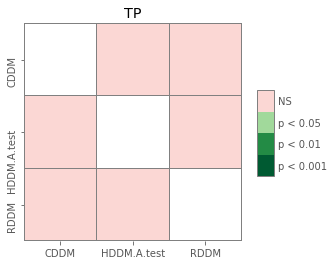

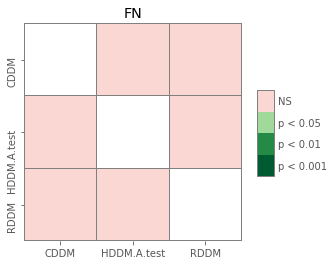

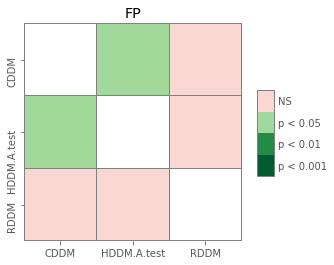

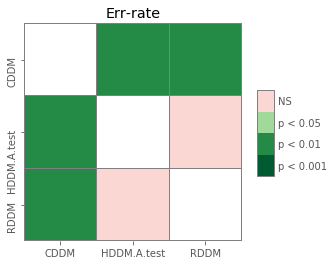

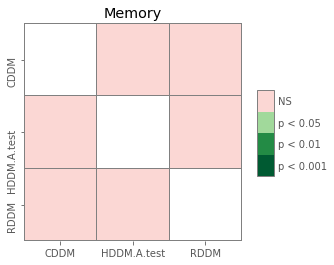

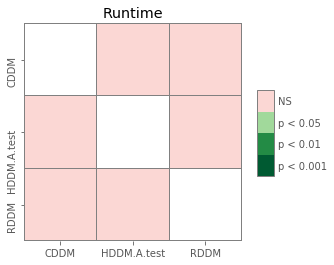

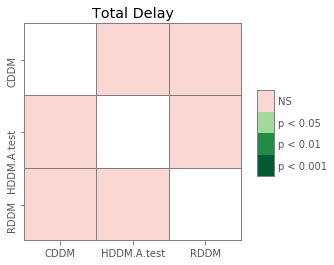

In [367]:
for col in results.columns[3:]:
    plt.figure()
#     display(Markdown('## '+col))
    pc = sp.posthoc_nemenyi(results, val_col=col, group_col='Detector')
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    plt.title(col)
    sp.sign_plot(pc, **heatmap_args);